**Objetive.** In this tutorial we illustrate the use of the package `carlin`. As running example we take the well-known [Van der Pol oscillator](https://es.wikipedia.org/wiki/Oscilador_de_van_der_Pol). 

CONTENTS:

- [Loading a model.](#Loading-the-model)
- [Computing the linearization](#Computing-the-linearization) and exporting to a .MAT file.
- [Computing the error term](#Computing-the-error-term) and plotting.
- [Using linearize](#Using-linearize). If you are just interested in obtaining the linearization, the function `linearize` presented in this section is probably enough.
- [Integration](#Integration) of the model ODE's, and plots in state-space. 
- [Integration of the linearized model](#Integration-of-the-linearized-model), plots and comparison to the nonlinear model.

## Loading the model

To read a model from a text file, we use the function `load_model`. The output is a list: 
- $f$: vector field
- $n$: dimension of the state-space
- $k$: order of the system

The example model `vanderpol.sage` reads as follows:

```python
# Van der pol oscillator
# ======================

# dimension of state-space
n=2

# define the vector of symbolic variables
x = polygens(QQ, ['x'+str(1+i) for i in range(n)])

# vector field (n-dimensional)
f = [None] * n

f[0] = x[1]
f[1] = x[1] - x[0]^2*x[1] - x[0]
```

In [1]:
%display typeset

In [2]:
from carlin.io import load_model 

[f, n, k] = load_model('vanderpol.sage')
f, n, k

([x2, -x1^2*x2 - x1 + x2], 2, 3)

## Computing the linearization

We can compute the linearization for each integer order $N$ using the function `truncated_matrix`.

In [3]:
from carlin.transformation import truncated_matrix

N = 4
AN = truncated_matrix(N, 'vanderpol.sage')

Notice that $A_N$ is a *sparse* matrix:

In [4]:
type(AN)

<class 'scipy.sparse.coo.coo_matrix'>

The `coo` tag says that it is internally represented as a list of tuples of coordiantes of non-zero values. Indeed, if you try to print `BN`, it will return a long dictionary of `(tuples, values)`.

In general, the matrices in Carleman linearization are very sparse, because they arise as a recursion of tensor products with the identity and the canonical description of the system.

If we want to transform it into a usual matrix (so called dense matrices), we can use the `toarray()` method. This is the analogue of MATLAB's `full(..)` function.

In [5]:
matrix(AN.toarray())    # the matrix(..) transforms it into a sage matrix (optional)

30 x 30 dense matrix over Real Double Field (use the '.str()' method to see the entries)

To export the linearization to an external MAT file, we can use the function `savemat`. Notice that other objects (possibly of different types) can be saved in the same MAT file, which will store them as a cell array. 

In [6]:
import scipy
from scipy.io import savemat

savemat('vanderpol.mat', {'model':'vanderpol', 'N':N, 'AN':AN})

This will generate the file `vanderpol.mat` in the working directory.

## Computing the error term

The error term is computed next. The interpretation is the following. Consider the inputs are the truncation order $N$, and an initial condition $x_0 \in \mathbb{R}^n$. The output is a function $\varepsilon(t)$ such that:
$$
x(t) \in \hat{x}(t) \oplus \mathcal{E}(t) \mathcal{B}^n_\infty, \qquad t \in I.
$$
The function $\varepsilon(t)$ has domain $[0,T^*] \subset \mathbb{R}^+$. The convergence radius $T^*$ is also given as an output. Here $x(t)$ is the exact solution of the original system, and $\hat{x}(t)$ is the solution of the linear system
$$
\hat{x}'(t) = A_N \hat{x}(t),\qquad t \in I.
$$
The quantity $\mathcal{B}^n_\infty$ represents the unit ball in the $n$-dimensional space corresponding to the supremum norm.

The error function is
$$
\mathcal{E}(t) = \dfrac{||x_0|| e^{||F_1||t}}{(1+\beta_0) - \beta_0 e^{||F_1||t}}\left[ \beta_0 (e^{||F_1|| t} - 1 )\right]^N.
$$
The data has to be reduced into the (canonical) quadratic degree. This is done internatlly in the function `quadratic_reduction`, which is called automatically by `error_function`. 

As an example, below we compute the error for the truncation order $N=4$.

In [8]:
from carlin.transformation import error_function

# truncation order
N=4

# initial condition
x0 = [1, 1]

[Ts, eps] = error_function('vanderpol.sage', N, x0)
Ts, eps

(0.27465307216702745,
 1.0*(0.5*e^(4.0*t) - 0.5)^4*e^(4.0*t)/(-0.5*e^(4.0*t) + 1.5))

The first output is interpreted as the convergence radius:

In [9]:
Ts

0.27465307216702745

It is convenient to work with a fraction of the convergence radius only:

In [10]:
Tfrac = 0.8

The second output is interpreted as the function $\varepsilon(t)$, which is is *increasing*, so $\varepsilon(t) \leq \varepsilon(T)$. Let us plot $\varepsilon(t)$.

/Users/forets/Tools/sage-master/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


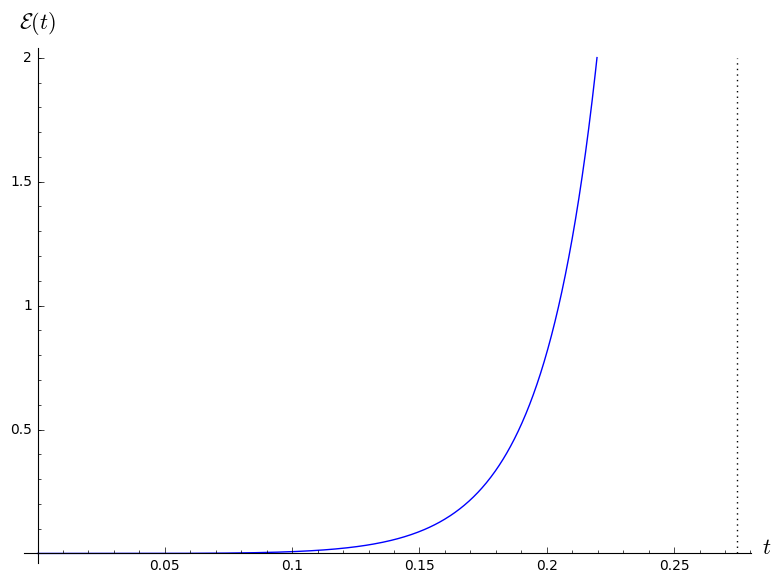

In [11]:
from carlin.transformation import plot_error_function

plot_error_function('vanderpol.sage', N, x0, Tfrac=Tfrac)

## Using `linearize`

We can as well use the `linearize` function which does the job of computing Carleman linearization to order $N$ and building the quadratic reduction. 

Here is an example:

In [12]:
# order
N = 4

# initial condition, x(0) = x0
x0 = [0.5, 0.5]

# set model filename, it should be in the working folder of the calling script
model_filename = 'vanderpol.sage'

# set target filename
target_filename = 'vanderpol_N_4.mat'

In [13]:
from carlin.transformation import linearize

linearize(model_filename, target_filename, N, x0)

Obtaining the canonical representation... done
Computing matrix BN... done
Computing the quadratic reduction... done
Computing the characteristics of the model... done
Exporting to  vanderpol_N_4.mat ... done


This produces the file `vanderpol_N_4.mat`, which can be opened in Sage with `loadmat`, or in other platforms eg. in MATLAB with the `load(..)` command.

## Integration 

Now, we compute the numerical solution of the ODE, and compare to the solution obtained by the linearized system. 

In [14]:
# symbolic state vector
x = polygens(QQ, ['x' + str(i) for i in range(1, n+1)])
x

(x1, x2)

The `ode_solver` object allows to register the parameters and the definition of the system that we want to solve.

In [15]:
S = ode_solver()

In [16]:
type(S)

<class 'sage.calculus.ode.ode_solver'>

The first task is to attach an ODE to the solver:

In [17]:
def f_1(t, x, params):
    return [x[1], -x[0]^2*x[1] - x[0] + x[1]]

S.function = f_1 

Some algorithms of GSL need to know additionally the Jacobian of the system, in the form `(i,j)`, these corresponding to `dfi/dyj` and last with the last row being `dfi/dt`.

In [18]:
def j_1(t, x, params):
    
    # jacobian
    dfi_dyj = [[f[i].derivative(x[j]) for j in range(n)] for i in range(n)]

    # we consider autonomous systems
    dfi_dt = [0]*n    
    
    return dfi_dyj + dfi_dt

S.jacobian = j_1

Finally, we define some model parameters:

In [40]:
# initial condition
x0 = [0.2, 0]

# initial time
t0 = 0

# final time
T = 12

To perform the **numerical integration**, one has to set:

- the algorithm,
- a time interval over which the solution is calculated, and
- the number of steps that we want, which determines the discretization step $h$.

In [41]:
# integration algorithm (valid options are: rk8pd, rk4, gear1)
S.algorithm = "rk4"

# initial time of simulation
t0ini = t0

# final time of simulation
Tfinal = T

# number of time samples
NPOINTS = 500

In [42]:
S.ode_solve(y_0 = x0, t_span = [t0ini,Tfinal], params=[0], num_points=NPOINTS)

#### Extracting the solution

The solution of an `ode_solver` object is a list of tuples, each tuple containing a time print and a tuple with the numerical values. 

For instance:

In [43]:
S.solution[37]

(0.8880000000000005, [0.09988356569471388, -0.24724734759684597])

We interpolate the solution, generating a list of tuples `(t, x_{i,t})` for each coordinate `i`. This is stored in the callable function `x_t` below.

In [44]:
x_t = lambda i : S.interpolate_solution(i)

For example, we can check the number of time samples of the solution:

In [45]:
len(x_t(0)), len(x_t(1))

(501, 501)

We can now plot the **position vs. time** solution:

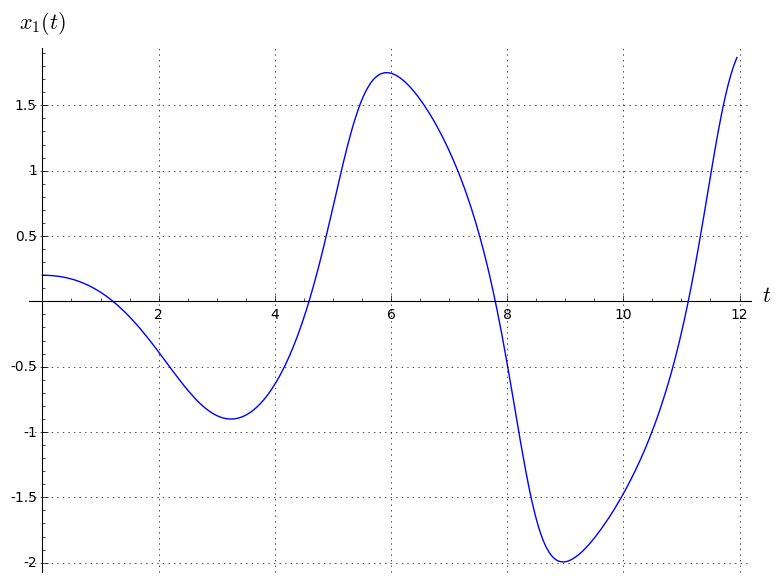

In [46]:
PosvsTime = plot(x_t(0), t0ini, Tfinal, axes_labels = ['$t$', '$x_1(t)$'], gridlines=True)
PosvsTime.legend_label = '($S$)'
PosvsTime.legend_color = 'black'

PosvsTime.show()

We can plot $x_2(t)$ as well:

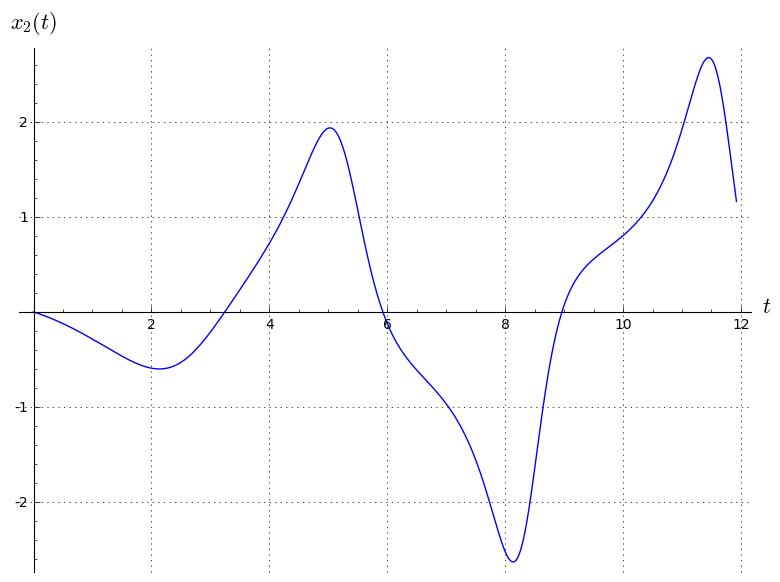

In [47]:
PosvsTime = plot(x_t(1), t0ini, Tfinal, axes_labels = ['$t$', '$x_2(t)$'], gridlines=True)
PosvsTime.legend_label = '($S$)'
PosvsTime.legend_color = 'black'

PosvsTime.show()

To plot the solution in **state space**:

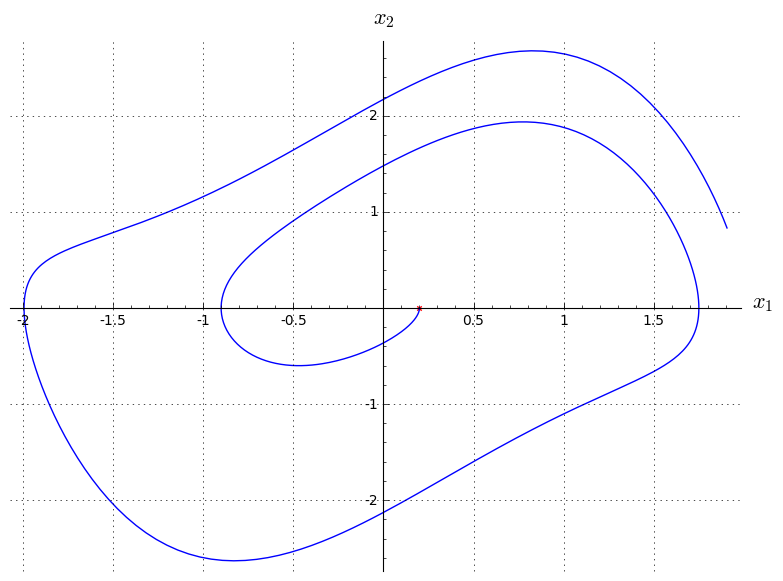

In [48]:
Graphic1 = Graphics()

# initial condition
Graphic1 += point(x0, marker='x', color='red')

# solution of the ODE in phase space
x1x2 = [S.solution[i][1] for i in range(len(S.solution))]
Graphic1 += list_plot(x1x2, plotjoined=True)

Graphic1.show(gridlines=True, axes_labels = ['$x_1$', '$x_2$'])

In [49]:
Graphic1.save("ssplot.png", gridlines=True)

## Integration of the linearized model

In [50]:
from carlin.transformation import truncated_matrix, kron_power

# truncation order
N = 2

AN = truncated_matrix(N, 'vanderpol.sage')

# cast into Sage dense matrix
AN = matrix(AN.toarray())

AN.nrows(), AN.ncols()

(6, 6)

In [51]:
AN

[ 0.0  1.0  0.0  0.0  0.0  0.0]
[-1.0  1.0  0.0  0.0  0.0  0.0]
[ 0.0  0.0  0.0  1.0  1.0  0.0]
[ 0.0  0.0 -1.0  1.0  0.0  1.0]
[ 0.0  0.0 -1.0  0.0  1.0  1.0]
[ 0.0  0.0  0.0 -1.0 -1.0  2.0]

We now solve $\hat{y}(t) = e^{A_N t} \hat{y}_0$. For $x_0$ given the initial condition in the lifted space can be found by using the method.

In [31]:
def initial_state_kron(x0, N):
    from carlin.transformation import kron_power

    y0 = kron_power(x0, 1)
    for i in [2..N]:
        y0 += kron_power(x0, i)
    return vector(y0)

In [58]:
# initial condition
x0 = [0.2, 0]

# transform to x0, x0^[2], ..., x0^[N]
y0 = initial_state_kron(x0, N)

# initial time
tini = 0

# final time
T = 5

# number of computation points
NPOINTS = 400

# time domain
from numpy import linspace
t_dom = linspace(tini, T, num=NPOINTS)

In [60]:
%%time

# compute solution
sol = [exp(AN*ti)*y0 for ti in t_dom]

CPU times: user 163 ms, sys: 1.97 ms, total: 165 ms
Wall time: 164 ms


In [61]:
sol_x1 = [sol[i][0] for i in range(NPOINTS)]
sol_x2 = [sol[i][1] for i in range(NPOINTS)]

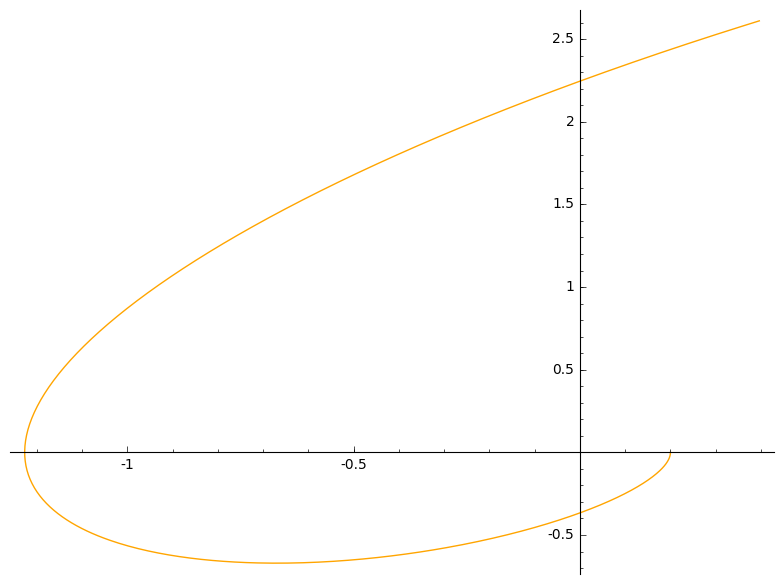

In [62]:
Graphic2 = list_plot(zip(sol_x1, sol_x2), plotjoined=True, color='orange')
Graphic2.show()

Finally, we plot together the linearized model of order $N$ and the numerical trajectory without linearization.

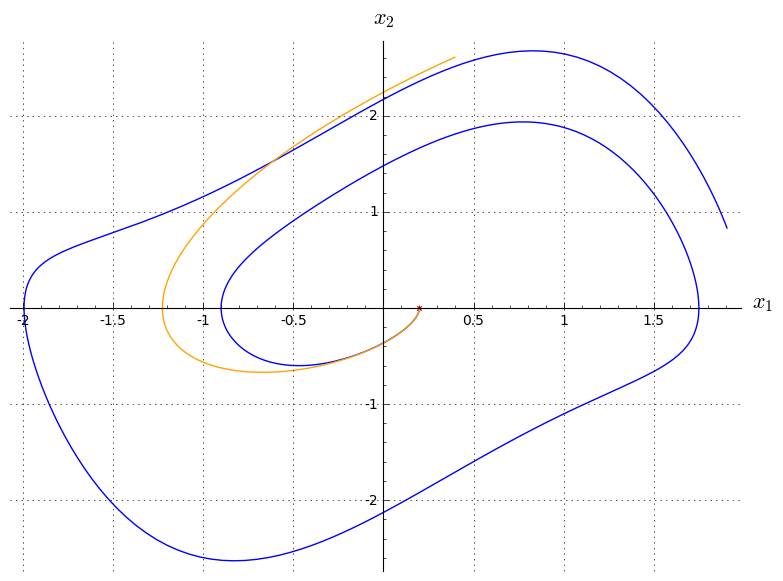

In [63]:
(Graphic1 + Graphic2).show(gridlines=True, axes_labels = ['$x_1$', '$x_2$'])